### For data preprocessing which includes CLAHE enchancement, balancing the dataset using Undersampling & Oversampling techniques, check out [this notebook](https://www.kaggle.com/code/rahulogoel/chest-x-rays-eda-clahe-enchanced-balanced).

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from os import listdir
import pickle
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense, Reshape
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import regularizers

%matplotlib inline

E0000 00:00:1730637575.206810      13 common_lib.cc:798] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:479
D1103 12:39:35.215761018      13 config.cc:196]                        gRPC EXPERIMENT call_status_override_on_cancellation   OFF (default:OFF)
D1103 12:39:35.215780849      13 config.cc:196]                        gRPC EXPERIMENT call_v3                                OFF (default:OFF)
D1103 12:39:35.215784786      13 config.cc:196]                        gRPC EXPERIMENT canary_client_privacy                  ON  (default:ON)
D1103 12:39:35.215787606      13 config.cc:196]                        gRPC EXPERIMENT capture_base_context                   ON  (default:ON)
D1103 12:39:35.215790297      13 config.cc:196]                        gRPC EXPERIMENT client_idleness                        ON  (defau

In [ ]:
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

# Detect TPU, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

Tensorflow version 2.16.1
Running on TPU  
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1730637604.447719      13 service.cc:145] XLA service 0x57b4f593ac90 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730637604.447782      13 service.cc:153]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1730637604.447787      13 service.cc:153]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1730637604.447790      13 service.cc:153]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1730637604.447793      13 service.cc:153]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1730637604.447796      13 service.cc:153]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1730637604.447799      13 service.cc:153]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1730637604.447809      13 service.cc:153]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1730637604.447811      13 service.cc:153]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


REPLICAS:  8


In [ ]:
df = pd.read_csv("../input/nih-balanced-and-resized-chest-x-rays/new_labels.csv")

In [ ]:
df.head()

,Path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
2,00000001_002.png,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
3,00000002_000.png,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,00000003_000.png,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [ ]:
data = df.sample(frac=1).reset_index(drop=True)

In [ ]:
data.head()

,Path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00019805_006.png,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,00002659_005.png,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,00008499_003.png,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,388340601423.png,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,00027685_006.png,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [ ]:
X = []
for i in tqdm(range(data.shape[0])):
    path = '../input/nih-balanced-and-resized-chest-x-rays/resized_images/resized_images/' + data['Path'][i][:12] +".png"
    img = image.load_img(path, target_size=(224, 224, 3))
    img = image.img_to_array(img)
    img = img/255.0
    X.append(img)

100%|██████████| 51382/51382 [04:28<00:00, 191.05it/s]


In [ ]:
X = np.array(X)
X.shape

(51382, 224, 224, 3)

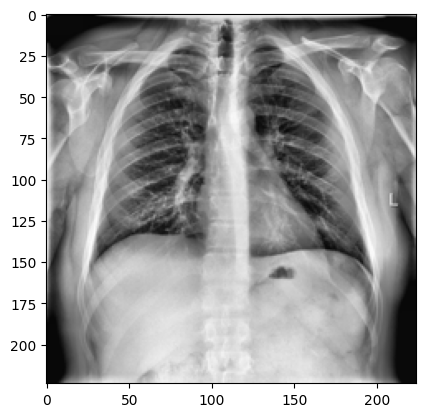

In [ ]:
plt.imshow(X[1])

In [ ]:
y = data.drop("Path", axis = 1)
y = y.to_numpy()
y.shape

(51382, 15)

In [ ]:
print(y[0])
y

[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 1]])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.18, shuffle =True)

In [ ]:
(X_train.shape, y_train.shape), (X_val.shape, y_val.shape), (X_test.shape, y_test.shape)

(((35812, 224, 224, 3), (35812, 15)),
 ((7862, 224, 224, 3), (7862, 15)),
 ((7708, 224, 224, 3), (7708, 15)))

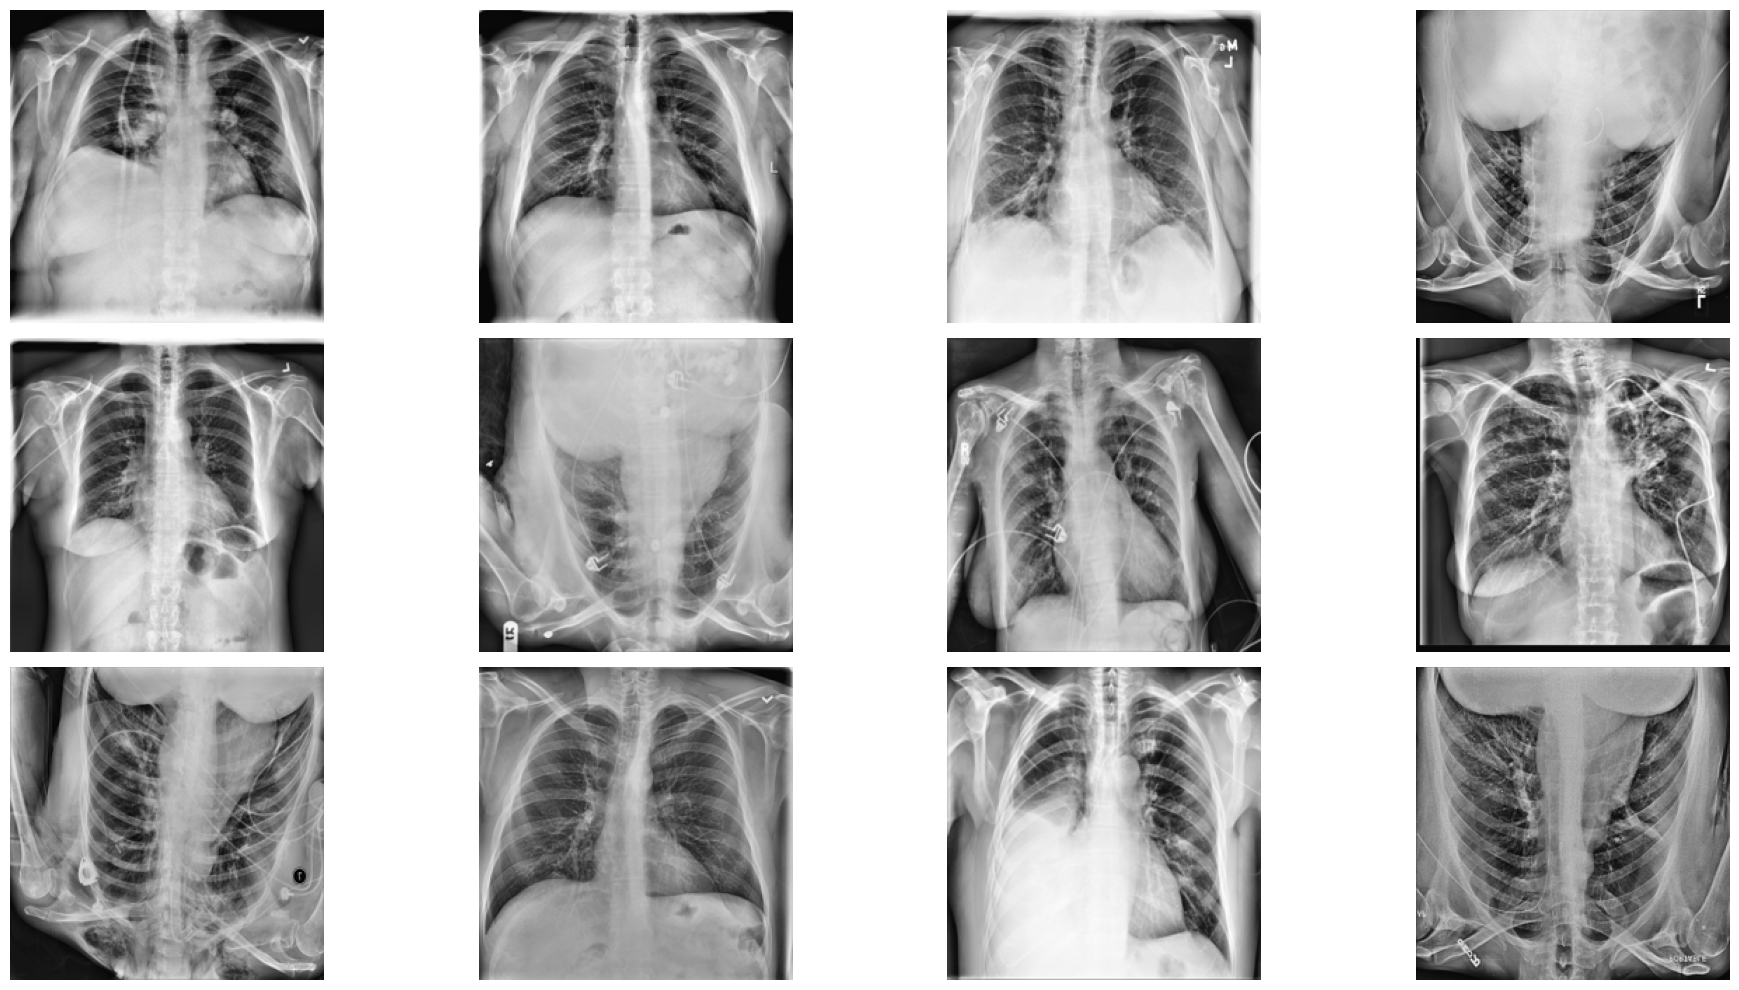

In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(20,10))
axes = axes.flatten()
for img, ax in zip(X, axes):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
import keras
from keras.applications import MobileNetV2
from keras import layers, models
from keras.models import Model
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping, TensorBoard

Model = 1 (epochs = 20, batch size = 64, learning rate = 1e-4)

In [ ]:
from keras import backend as K
K.clear_session()

In [ ]:
with strategy.scope():
    base_model = MobileNetV2(weights='imagenet', include_top=False)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(15, activation="sigmoid")(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    opt = tf.keras.optimizers.Adam(learning_rate = 1e-4)
    model.compile(loss="binary_crossentropy", 
                  optimizer = opt,
                  metrics = ["binary_accuracy", 
                             "f1_score",
                             tf.keras.metrics.Recall(),
                             tf.keras.metrics.Precision(),
                             tf.keras.metrics.AUC])

/tmp/ipykernel_13/3605138481.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False)
I0000 00:00:1730301084.746035      13 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Train the model
history = model.fit(
    X_train, y_train, 
    batch_size = 64,
    validation_data = (X_val, y_val),
    steps_per_epoch = len(X_train) // 64,
    epochs = 20,
    verbose=1)

Epoch 1/20


2024-10-30 15:12:24.297283: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.
I0000 00:00:1730301146.032507     831 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(4735180edeb8cf7c:0:0), session_name()


  1/559 ━━━━━━━━━━━━━━━━━━━━ 4:08:26 27s/step - auc: 0.5140 - binary_accuracy: 0.3656 - f1_score: 0.0367 - loss: 0.8963 - precision: 0.1040 - recall: 0.6700

I0000 00:00:1730301160.540798     831 tpu_compile_op_common.cc:245] Compilation of 4735180edeb8cf7c:0:0 with session name  took 14.508246906s and succeeded
I0000 00:00:1730301160.602616     831 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(4735180edeb8cf7c:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_15059484255722236667", property.function_library_fingerprint = 1265494779150534100, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "8,224,224,3,;8,15,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1730301160.602674     831 tpu_compilation_cache_interface.cc:541] After adding entry for key

558/559 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - auc: 0.6898 - binary_accuracy: 0.8735 - f1_score: 0.1981 - loss: 0.3325 - precision: 0.3059 - recall: 0.0969

I0000 00:00:1730301199.234139     813 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(efac4dde24b19ac5:0:0), session_name()


559/559 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - auc: 0.6899 - binary_accuracy: 0.8735 - f1_score: 0.1982 - loss: 0.3324 - precision: 0.3062 - recall: 0.0969

I0000 00:00:1730301214.101485     813 tpu_compile_op_common.cc:245] Compilation of efac4dde24b19ac5:0:0 with session name  took 14.867300465s and succeeded
I0000 00:00:1730301214.177580     813 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(efac4dde24b19ac5:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_15059484255722236667", property.function_library_fingerprint = 1265494779150534100, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "5,224,224,3,;5,15,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1730301214.177631     813 tpu_compilation_cache_interface.cc:541] After adding entry for key

559/559 ━━━━━━━━━━━━━━━━━━━━ 104s 139ms/step - auc: 0.6900 - binary_accuracy: 0.8736 - f1_score: 0.1983 - loss: 0.3323 - precision: 0.3065 - recall: 0.0969 - val_auc: 0.6879 - val_binary_accuracy: 0.8521 - val_f1_score: 0.1315 - val_loss: 0.3675 - val_precision: 0.2347 - val_recall: 0.2226
Epoch 2/20


I0000 00:00:1730301238.204730     768 tpu_compile_op_common.cc:245] Compilation of c75e6c451aa6986c:0:0 with session name  took 3.564080393s and succeeded
I0000 00:00:1730301238.214933     768 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(c75e6c451aa6986c:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_10072573949289887355", property.function_library_fingerprint = 14646456749222024298, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "7,224,224,3,;7,15,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1730301238.214959     768 tpu_compilation_cache_interface.cc:541] After adding entry for key

559/559 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - auc: 0.0000e+00 - binary_accuracy: 0.0000e+00 - f1_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_auc: 0.6879 - val_binary_accuracy: 0.8521 - val_f1_score: 0.1315 - val_loss: 0.3675 - val_precision: 0.2347 - val_recall: 0.2226
Epoch 3/20
559/559 ━━━━━━━━━━━━━━━━━━━━ 44s 78ms/step - auc: 0.8296 - binary_accuracy: 0.9132 - f1_score: 0.3380 - loss: 0.2448 - precision: 0.7360 - recall: 0.1861 - val_auc: 0.7605 - val_binary_accuracy: 0.9032 - val_f1_score: 0.2525 - val_loss: 0.2852 - val_precision: 0.5465 - val_recall: 0.0972
Epoch 4/20
559/559 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - auc: 0.7879 - binary_accuracy: 0.9200 - f1_score: 0.1111 - loss: 0.2523 - precision: 0.6667 - recall: 0.2856 - val_auc: 0.7630 - val_binary_accuracy: 0.9029 - val_f1_score: 0.2522 - val_loss: 0.2843 - val_precision: 0.5351 - val_recall: 0.0999
Epoch 5/20
559/559 ━━━━━━━━━━━━━━━━━━━━ 44s 79ms/step - auc: 0.8675 - binary_accuracy: 0.91

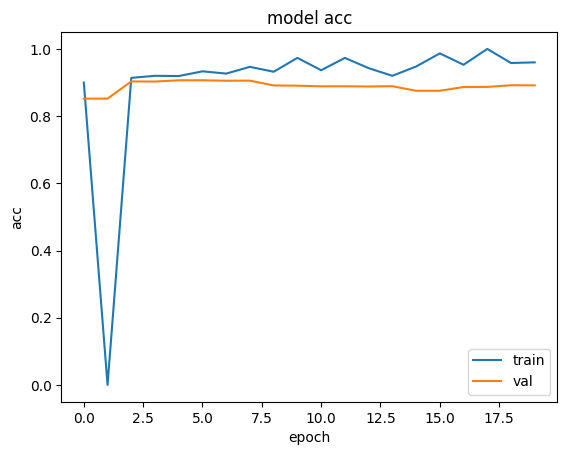

In [ ]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

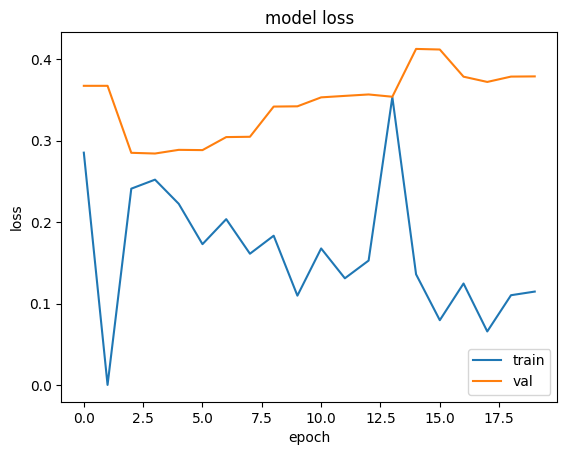

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

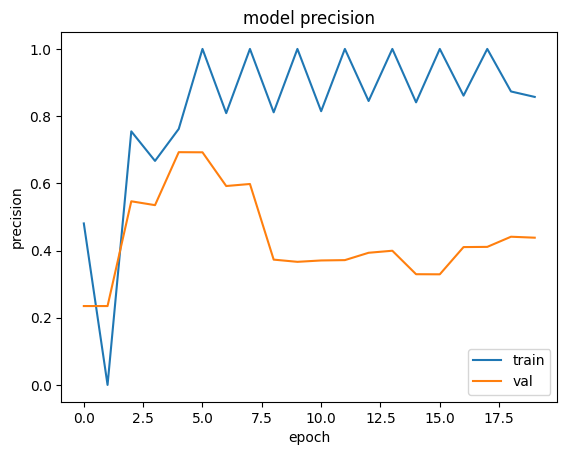

In [ ]:
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

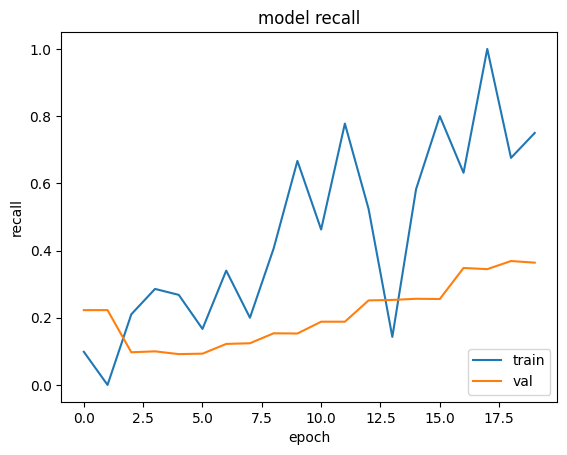

In [ ]:
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

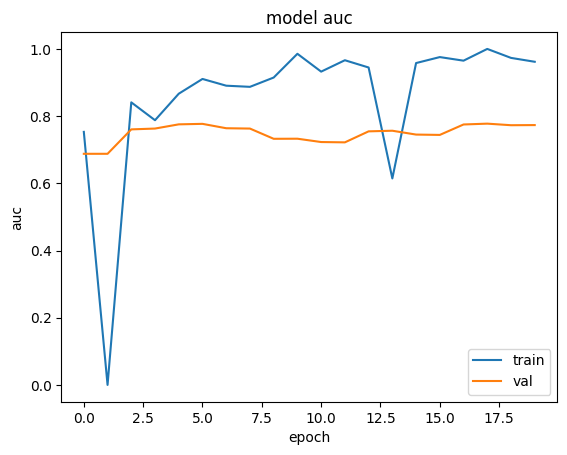

In [ ]:
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

In [ ]:
scores = model.evaluate(X_test, y_test, return_dict = True)

I0000 00:00:1730301732.400866     826 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(962ae2b706de166b:0:0), session_name()


  7/241 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - auc: 0.8046 - binary_accuracy: 0.8953 - f1_score: 0.2293 - loss: 0.3625 - precision: 0.5264 - recall: 0.4204

I0000 00:00:1730301736.231016     826 tpu_compile_op_common.cc:245] Compilation of 962ae2b706de166b:0:0 with session name  took 3.830065273s and succeeded
I0000 00:00:1730301736.245270     826 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(962ae2b706de166b:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_10072573949289887355", property.function_library_fingerprint = 14646456749222024298, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "4,224,224,3,;4,15,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1730301736.245303     826 tpu_compilation_cache_interface.cc:541] After adding entry for key

241/241 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - auc: 0.7889 - binary_accuracy: 0.8953 - f1_score: 0.3233 - loss: nan - precision: 0.4691 - recall: 0.3869   


In [ ]:
scores

{'auc': 0.769110918045044,
 'binary_accuracy': 0.8919777274131775,
 'f1_score': <tf.Tensor: shape=(15,), dtype=float32, numpy=
 array([0.16417907, 0.46073294, 0.23684207, 0.49999994, 0.2836363 ,
        0.46357605, 0.43312097, 0.821192  , 0.06779657, 0.38626605,
        0.30088487, 0.05970148, 0.24719097, 0.08547007, 0.13008127],
       dtype=float32)>,
 'loss': 0.3778524696826935,
 'precision': 0.4340611398220062,
 'recall': 0.3522324562072754}

Model = 2 (epochs = 50, batch size = 64, learning rate = default(0.001))

In [ ]:
from keras import backend as K
K.clear_session()

In [ ]:
# Parameters
input_shape = (224, 224, 3)  # Input shape for MobileNetV2
num_classes = 15              # Number of binary classes
batch_size = 64               # Batch size
epochs = 50                   # Number of epochs

In [ ]:
with strategy.scope():
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False
    model = models.Sequential([
        layers.InputLayer(input_shape=input_shape),
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(num_classes, activation='sigmoid')
    ])

In [ ]:
with strategy.scope():
    model.compile(optimizer='adam', 
        loss='binary_crossentropy', 
        metrics = (["binary_accuracy", 
            "f1_score",
             tf.keras.metrics.Recall(),
             tf.keras.metrics.Precision(),
             tf.keras.metrics.AUC]))

In [ ]:
# Train the model
history = model.fit(
    X_train, y_train, 
    batch_size = 64,
    validation_data = (X_val, y_val),
    steps_per_epoch = len(X_train) // 64,
    epochs = 50,
    verbose=1)

Epoch 1/50


2024-11-03 15:18:13.723355: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.
I0000 00:00:1730647094.381910     755 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(983dd092db63f256:0:0), session_name()


  5/559 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - auc: 0.5452 - binary_accuracy: 0.6693 - f1_score: 0.0225 - loss: 0.6405 - precision: 0.1142 - recall: 0.3678 

I0000 00:00:1730647097.797231     755 tpu_compile_op_common.cc:245] Compilation of 983dd092db63f256:0:0 with session name  took 3.415260701s and succeeded
I0000 00:00:1730647097.811481     755 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(983dd092db63f256:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_14389002418184672837", property.function_library_fingerprint = 1896247121626646584, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "8,224,224,3,;8,15,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1730647097.811533     755 tpu_compilation_cache_interface.cc:541] After adding entry for key 

556/559 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.6580 - binary_accuracy: 0.8932 - f1_score: 0.1744 - loss: 0.3207 - precision: 0.3796 - recall: 0.0448

I0000 00:00:1730647114.209802     813 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(9d9cba7eea78a68e:0:0), session_name()


559/559 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - auc: 0.6583 - binary_accuracy: 0.8933 - f1_score: 0.1746 - loss: 0.3206 - precision: 0.3805 - recall: 0.0448

I0000 00:00:1730647118.161718     813 tpu_compile_op_common.cc:245] Compilation of 9d9cba7eea78a68e:0:0 with session name  took 3.951862177s and succeeded
I0000 00:00:1730647118.176995     813 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(9d9cba7eea78a68e:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_14389002418184672837", property.function_library_fingerprint = 1896247121626646584, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "5,224,224,3,;5,15,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1730647118.177039     813 tpu_compilation_cache_interface.cc:541] After adding entry for key 

559/559 ━━━━━━━━━━━━━━━━━━━━ 53s 82ms/step - auc: 0.6584 - binary_accuracy: 0.8933 - f1_score: 0.1746 - loss: 0.3205 - precision: 0.3809 - recall: 0.0449 - val_auc: 0.7459 - val_binary_accuracy: 0.9069 - val_f1_score: 0.2298 - val_loss: 0.2773 - val_precision: 0.6543 - val_recall: 0.0860
Epoch 2/50


I0000 00:00:1730647143.537187     784 tpu_compile_op_common.cc:245] Compilation of 19ac50ddf91960f6:0:0 with session name  took 4.248679589s and succeeded
I0000 00:00:1730647143.550263     784 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(19ac50ddf91960f6:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_1980337781494592757", property.function_library_fingerprint = 12294251116682541531, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "7,224,224,3,;7,15,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1730647143.550298     784 tpu_compilation_cache_interface.cc:541] After adding entry for key 

559/559 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - auc: 0.0000e+00 - binary_accuracy: 0.0000e+00 - f1_score: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_auc: 0.7459 - val_binary_accuracy: 0.9069 - val_f1_score: 0.2298 - val_loss: 0.2773 - val_precision: 0.6543 - val_recall: 0.0860
Epoch 3/50
559/559 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - auc: 0.7695 - binary_accuracy: 0.9059 - f1_score: 0.2621 - loss: 0.2737 - precision: 0.6898 - recall: 0.0935 - val_auc: 0.7678 - val_binary_accuracy: 0.9080 - val_f1_score: 0.2408 - val_loss: 0.2699 - val_precision: 0.6745 - val_recall: 0.0999
Epoch 4/50
559/559 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - auc: 0.7376 - binary_accuracy: 0.8135 - f1_score: 0.1000 - loss: 0.4656 - precision: 3.3542e-04 - recall: 4.6586e-05 - val_auc: 0.7666 - val_binary_accuracy: 0.9077 - val_f1_score: 0.2345 - val_loss: 0.2704 - val_precision: 0.6509 - val_recall: 0.1055
Epoch 5/50
559/559 ━━━━━━━━━━━━━━━━━━━━ 23s 39ms/step - auc: 0.7886 - binary_accura

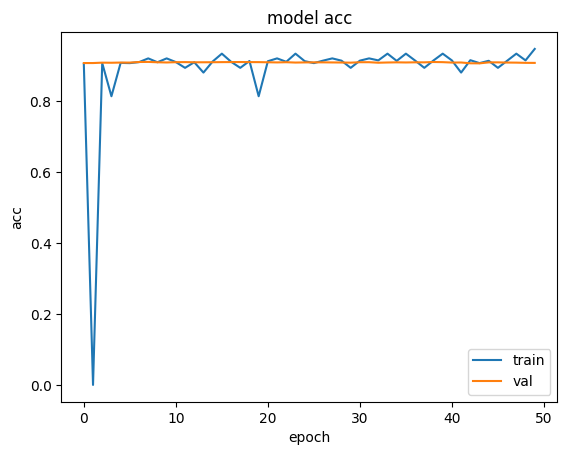

In [ ]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

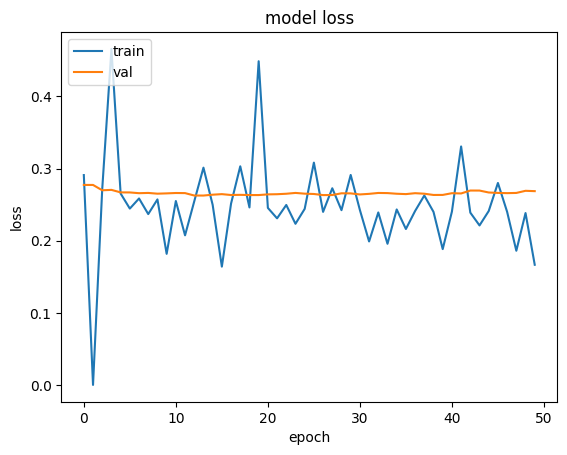

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

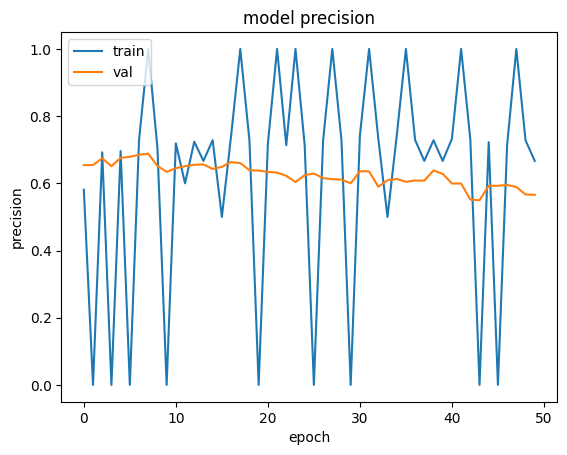

In [ ]:
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

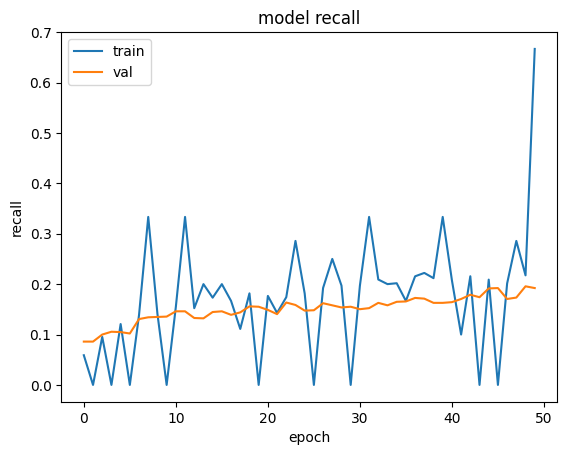

In [ ]:
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

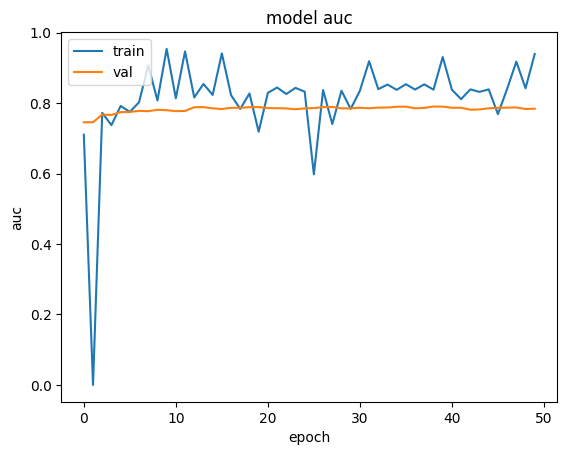

In [ ]:
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
scores = model.evaluate(X_test, y_test, return_dict = True)

241/241 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - auc: 0.7911 - binary_accuracy: 0.9070 - f1_score: 0.2874 - loss: nan - precision: 0.5910 - recall: 0.1995   


In [ ]:
scores

{'auc': 0.7940057516098022,
 'binary_accuracy': 0.90656977891922,
 'f1_score': <tf.Tensor: shape=(15,), dtype=float32, numpy=
 array([0.27807483, 0.35582817, 0.07692304, 0.3506493 , 0.1428571 ,
        0.34482753, 0.2926829 , 0.7083333 , 0.06201547, 0.09929075,
        0.3060109 , 0.25742567, 0.19161673, 0.4444444 , 0.34482753],
       dtype=float32)>,
 'loss': 0.27007627487182617,
 'precision': 0.6223628520965576,
 'recall': 0.20109066367149353}

### Some findings after training models with different hyperparameters:

- `Batch size` is the number of training examples used in one iteration of model training. Here it is kept same at **64** in both models.

- `Epoch` represents one complete pass through the entire training dataset. It should not be too high/small otherwise it will lead to overfitting/underfitting of data which further leads to an increase in loss of our model. By comparing **Model = 1** and **Model = 2**, we can see that increase in epochs will result in **increase in Accuracy, AUC & Precision** which is good for our model.

- `Learning rate` influences how quickly the model converges. In **Model = 2** our loss is less than **Model = 1**. So, it should be kept at **0.001**.


#### Lastly, the optimal model comes out to be Model = 2 where `epochs = 50`, `batch_size = 64` & `learning_rate = 1e-3`.